# High Performance Computing

In this exercise, we will continue the molecular dynamics simulation of a protein-ligand complex from the previous exercise using high performance computing. High performance computing environments allow you to run multiple calculations continuously for hours without being continuously connected to the internet. We will use the [Bridges-2 resource](https://www.psc.edu/resources/bridges-2/user-guide/) run by the Pittsburg Supercomputer Center and made available through the National Science Foundation [ACCESS-CI](https://access-ci.org/) program.

When you are done with this exercise, save it under your shared exercises folder on Google Drive. It will be graded as satisfactory or unsatisfactory based on correctly completing the sections after `-->`. Do not remove the symbol `-->`.

Read [Getting Started with High Performance Computing](https://www.psc.edu/resources/bridges-2/getting-started-with-hpc/). We will connect to Bridges-2 using the web browser interface **OnDemand**. It is possible to run an **interactive session** with a Jupyter Notebook, which is similar to Google Colab. However, we will use **batch processing** instead; this approach allows you to run multiple jobs at once.

## Part 1 - Using the LINUX shell on Bridges-2

--> Log in to [OnDemand](https://ondemand.bridges2.psc.edu/). You may need to set your PSC password. What are the Pinned Apps?

Practice using the bash shell. Open the `Bridges-2 Shell Access` App. Your project directory should be `/ocean/projects/che240058p/{USERNAME}`, where `{USERNAME}` is your PSC user name.

Some essential bash commands are, \\
pwd - print working directory \\
ls - list \\
cd - change directory \\
mkdir - make directory \\

--> Create the directory `exercises` within your project directory. Create the directories `08-OpenMM-{SYSTEM_NAME}` and `09-HPC-{SYSTEM_NAME}` within the exercises directory, where `{SYSTEM_NAME}` is the name of the system that you are simulating, e.g. `ADORA2A-LUF5448`. Change the directory to your project directory, take a partial screenshot of the results of `ls exercises/`, and replace the image below.

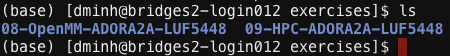

## Part 2 - Transferring data to Bridges-2

Read the section on [Transferring Files](https://www.psc.edu/resources/bridges-2/user-guide/#transferring-files) in the Bridges-2 user guide. It is not straightforward to use these options with Google Colab or Google Drive. For this reason, we will use `wget` and download the data to Bridges-2. Because Google Drive has an virus warning for large files, we need to compress our files first.

### Mounting Google Drive

In [ ]:
import os

# Check for directory and input files
if not os.path.isdir('/content/drive'):
  from google.colab import drive
  drive.mount('/content/drive')

### Compressing files

You should have system xml from Exercise 6 and the state xml and coordinate files from step 4 of Exercise 8.

--> Modify the code below to point to the appropriate paths.

In [ ]:
USERNAME = 'dminh'
SYSTEM_NAME = 'ADORA2A-LUF5448'

DIR = os.path.join('/content','drive','MyDrive','Classes','Chem 456 2024F','students','dminh','exercises')}

FNs = [os.path.join(DIR, f'06-System_Preparation/{SYSTEM_NAME}.xml'),
       os.path.join(DIR, f'08-OpenMM-{SYSTEM_NAME}/Step_4.xml'),
       os.path.join(DIR, f'08-OpenMM-{SYSTEM_NAME}/Step_4.pdb')]
for FN in FNs:
  if not os.path.isfile(FN):
    raise Exception('Required file missing!')
  if not os.path.isfile(FN+'.gz'):
    !gzip -k '{FN}'

--> Find and share the files on Google Drive, making them accessible to anyone with a link. The link `https://drive.google.com/file/d/{FILE_ID}/view?usp=sharing` has `FILE_ID` in the middle. Define the variables below based on your sharing links.

In [ ]:
FILE_ID = {\
  f'{SYSTEM_NAME}.xml.gz':'', \
  'Step_4.pdb.gz':'', \
  'Step_4.xml.gz':''}

for key in FILE_ID.keys():
  print(f"wget --no-check-certificate 'https://docs.google.com/uc?export=download&id={FILE_ID[key]}' -O {key}")
  print(f"gunzip {key}")

### Downloading from Google Drive onto Bridges-2

--> Now download these files from your Google Drive to Bridges-2. On the terminal, go to the `/ocean/projects/che240058p/{USERNAME}/exercises/08-OpenMM-{SYSTEM_NAME}` directory and use the command `wget --no-check-certificate 'https://docs.google.com/uc?export=download&id={FILE_ID}' -O {FILE_NAME}` command. If you properly entered data into the cell above, you should be able to copy and paste the output into the Bridges-2 terminal. After you have downloaded the files, take a partial screenshot of the result of `pwd` and `ls` and replace the image below.

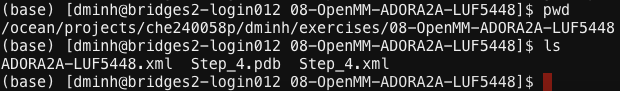

## Part 3 - Setting up software on Bridges-2

Bridges-2 has a wide range of [available software](https://www.psc.edu/resources/software/). However we are using some specialized packages that are not loaded.

--> Enter the following lines on the terminal to install OpenMM:

```bash
module load anaconda3
conda activate
conda create --name OpenMM
conda activate OpenMM
conda install -c conda-forge openmm mdtraj
```

--> Now change to your home directory by typing `cd /jet/home/{USERNAME}` or by simply typing `cd`. Create a folder called `GitHib` and change to that directory. To download MotorRow, enter `git clone https://github.com/CCBatIIT/MotorRow.git`.

## Part 4 - Submitting a molecular dynamics simulation to the job queue

Read the description of [batch jobs](https://www.psc.edu/resources/bridges-2/user-guide/#batch-jobs). The code below will generate a job script. The first part of the script are [sbatch options](https://www.psc.edu/resources/bridges-2/user-guide/#sbatch-opts). The latter is a bash script, which includes writing a python script. Use a text editor such as `nano` or `vim` and save it as `{SYSTEM_NAME}_step_5.job`.

In [ ]:
DIR = {'IN':f'/ocean/projects/che240058p/{USERNAME}/exercises/08-OpenMM-{SYSTEM_NAME}',
       'OUT':f'/ocean/projects/che240058p/{USERNAME}/exercises/09-HPC-{SYSTEM_NAME}'}
FN = {'system_xml': os.path.join(DIR['IN'],f'{SYSTEM_NAME}.xml'),
      'state_xml':  os.path.join(DIR['IN'],f'Step_4.xml'),
      'pdb':        os.path.join(DIR['IN'],f'Step_4.pdb')}

print(f"""#!/bin/bash
#SBATCH -p GPU-shared
#SBATCH -t 48:00:00
#SBATCH -N 1
#SBATCH --gpus=v100-16:1
#SBATCH -A che240058p
#SBATCH --mail-type=ALL

#echo commands to stdout
set -x

module load anaconda3
conda activate OpenMM
export PYTHONPATH=/jet/home/{USERNAME}/GitHub/MotorRow/:$PYTHONPATH
cd $LOCAL

cat > Step_5.py <<EOF

from MotorRow import MotorRow
MR = MotorRow('{FN['system_xml']}', \\
              '{FN['pdb']}', \\
              '/local')
MR._run_step('{FN['state_xml']}', 5, nsteps=10000000)

EOF

python Step_5.py
mkdir -p {DIR['OUT']}
cp * {DIR['OUT']}/
rm *
""")

--> After you have created the file, submit the job using the command `sbatch {SYSTEM_NAME}_step_5.job`. Take a partial screenshot of the result of this command and replace the image below.

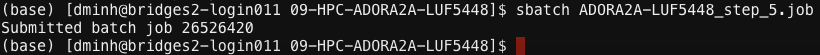

After you submit the job, it will be on the queue until a compute node is available. You will receive emails when the job starts and completes. If your job completes in less than a minute than you probably have done something incorrectly. It should take a few hours.

You may also use `slurm-tool queue` or [other commands](https://www.psc.edu/resources/bridges-2/user-guide/#batch-jobs) to check your job status.

In the next exercise, we will perform some analysis of this simulation.